In [167]:
# 필요한 모듈

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<br>

## 트랜스포머 모델에 필요한 함수들 작성 <br><br>

- Positional Encoding Layer (포지셔널 인코딩 레이어) <br>
- Scaled Dot-product Attention (프로덕트 닷-프로덕트 어텐션) <br>
- Multi-head Attention (멀티-헤드 어텐션) <br>
- Padding Mask (패딩 마스크) <br>
- Look-ahead Mask (룩-어헤드 마스크) <br>
- Encoder (인코더) <br>
- Decoder (디코더) <br>

<br>

<br>

## 챗봇 병렬 데이터 읽어오기 <br><br>

__Chatbot_data_for_Korean v1.0 데이터셋__ <br>
- 합습용 질문/답면 쌍 11,823개 <br>
- 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2 로 레이블링 <br><br>

- 11,823개 질문/답변 쌍을 추출 <br>
- 문장에서 단어와 구두점 사이에 공백 추가 <br>
- 알파벳과 ! ? , . 이 4개의 구두점을 제외한 다른 특수문자 모두 제거

<br>

In [168]:
# 데이터 불러오기

data = pd.read_csv(os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData.csv")

print('전체 샘플수 :',(len(data)))

전체 샘플수 : 11823


In [169]:
# 데이터 샘플 확인

data.head(10)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


<br>

## 데이터 전처리

<br>

<br>

### 데이터셋 가공을 위한 전처리 함수 <br>

__정규 표현식(Regular Expression)__을 사용하여 __구두점(punctuation)__을 제거하여 <br>
단어를 __토크나이징(tokenizing)__하는 일에 방해가 되지 않도록 정제하는 것을 목표 <br><br>

단어를 토크나이징 하는 과정에서 구두점과 붙어있던 단어들을 하나의 단어로 인식하는 것을 방지하기 위해 <br>
제거할 대상들을 공백으로 대체합니다.

<br>

In [173]:
# 전처리 함수

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 구두점도 문장내 단어위치에 따라 유의미 하다고 판단하여 구두점 제거는 하지 않았습니다.
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  # sentence = re.sub(r'[" "]+', " ", sentence)

  # (ㄱ-ㅎ, 가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [174]:
# 전처리 함수 확인

temp_text = '안녕하세요, 김덕배입니다.'
temp_summary = '반갑습니다, 좋은 날씨네요!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary))

안녕하세요, 김덕배입니다.
반갑습니다, 좋은 날씨네요!!!


<br>

### 질문과 답변 각각에 대해 전처리
질문과 답변의 쌍 각각에 대해 전처리 함수를 이용하여 전처리

<br>

In [176]:
# 'Q' 칼럼의 데이터 전처리 (불용어 제거)

inputs = []

# 'Q' 칼럼 전체 데이터에 대한 전처리
for s in data['Q']:
    inputs.append(preprocess_sentence(s))

# 전처리 후 출력 확인
inputs[:5]

['시 땡!', '지망 학교 떨어졌어', '박 일 놀러가고 싶다', '박 일 정도 놀러가고 싶다', 'ppl 심하네']

In [177]:
# 'A' 칼럼의 데이터 전처리 (불용어 제거)

outputs = []

# 'A' 칼럼 전체 데이터에 대한 전처리
for s in data['A']:
    outputs.append(preprocess_sentence(s))

# 전처리 후 출력 확인
outputs[:5]

['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']

<br>

#### 데이터의 샘플 수 확인 <br><br>

질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 합니다. <br><br>

임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 <br>
질문과 답변이 병렬적으로 잘 저장은 되었는지, 그리고 전처리 함수에서 의도했던 전처리가 진행되었는지 확인

<br>

In [178]:
# 전처리 후 데이터 샘플 수 확인

print('전체 샘플 수 :', len(inputs))
print('전체 샘플 수 :', len(outputs))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [179]:
# 22번째 샘플 출력해서 질문/답변 병렬저장, 전처리 확인

print('전처리 후의 22번째 질문 샘플: {}'.format(inputs[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(outputs[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요.


<br>

## 병렬 데이터 전처리 <br><br>

1. 각 문장을 토큰화하고, 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가 <br><br>

2. TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용 <br>
    - 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징 <br>
    - 각 토큰을 고유한 정수로 인코딩 <br><br>

3. 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링 <br><br>

4. MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩


<br>

<br>

### 1. 단어장(Vocabulary) 만들기 <br><br>

각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary) 생성 <br>
단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용 ! <br><br>

tensorflow_datasets 에서 <br>
tensorflow_datasets.deprecated.text.SubwordTextEncoder.build_from_corpus 이용

<br>

In [180]:
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.2.0 이하)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**13)

# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
#tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**13)

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐


<br>

#### 시작/종료 토큰도 단어장에 추가 <br>
디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해 줍니다. <br>
이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 됩니다. 

<br>

In [181]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [182]:
# 시작 토큰, 종료 토큰에 부여된 정수 확인

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


<br>

현재 단어장의 크기가 8,331(0번부터 8,330번)이라는 의미 ! <br>
두 개의 토큰을 추가해주었기 때문에 단어장의 크기도 +2임을 명시

<br>

In [183]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정

VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


<br>

### 2. 각 단어를 고유한 정수로 인코딩 & 패딩 <br><br>

위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 생성하였으므로 <br><br>

tokenizer.encode()로 각 단어를 정수로 변환할 수 있고, 또는, <br>
tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다 ! <br><br>

22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과 확인

<br>

In [184]:
# 22번째 샘플 데이터 확인

print(inputs[21])
print(outputs[21])

가스비 장난 아님
다음 달에는 더 절약해봐요.


In [185]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환

print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(inputs[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(outputs[21])))

정수 인코딩 후의 21번째 질문 샘플: [5739, 607, 2483, 4145]
정수 인코딩 후의 21번째 답변 샘플: [2351, 7484, 5, 6250, 94, 7923]


<br>

각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인 가능 <br>
질문과 답변 셋에 대해서 전부 정수 인코딩을 수행한 뒤, 문장의 최대 길이를 정하고 해당 길이로 패딩(padding)

<br>

In [186]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이

MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [187]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩

def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

<br>

정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다. <br>
단어장의 크기와 샘플의 개수를 확인 !

<br>

In [188]:
# 정수 인코딩, 패딩 과정에서 일부 샘플 제외 후 단어장 크기 및 샘플 개수 확인

inputs, outputs = tokenize_and_filter(inputs, outputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(inputs)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(outputs)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


<br>

## 데이터셋 준비 <br><br>

질문과 답변의 쌍을 tf.data.Dataset API 의 입력으로 사용하여 파이프라인을 구성 <br><br><br>


### 교사 강요 (Teacher Forcing) 적용 <br><br>

이때, 교사 강요를 위해서 <br>
```answers[:, :-1]``` 를 디코더의 입력값, ```answers[:, 1:]``` 를 디코더의 레이블로 사용합니다.

<br>

In [189]:
# 데이터 파이프라인 (학습 데이터셋) 구성
# 데이터셋 구성시 교사 강요 적용

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': inputs,
        'dec_inputs': outputs[:, :-1]
    },
    {
        'outputs': outputs[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

<br>

## 트랜스포머 모델에 필요한 함수들 작성 <br><br>

- Positional Encoding Layer (포지셔널 인코딩 레이어) <br><br>


- Scaled Dot-product Attention (프로덕트 닷-프로덕트 어텐션) <br>
- Multi-head Attention (멀티-헤드 어텐션) <br><br>


- Padding Mask (패딩 마스크) <br>
- Look-ahead Mask (룩-어헤드 마스크) <br><br>


- Encoder (인코더) <br>
- Decoder (디코더) <br>

<br>

<br>

### 포지셔널 인코딩 (Positional Encoding) <br><br>

임베딩 문장 행렬에 포지셔널 인코딩을 해주었을 때, <br>
같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로, <br>
같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있습니다. <br><br>


### 포지셔널 인코딩 레이어 <br>
인코더와 디코더 함수에 들어가기 위한 포지셔널 인코딩 레이어 함수를 작성

<br>

In [190]:
# 포지셔널 인코딩 레이어 작성

class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

<br>

### Scaled Dot-product Attention <br>

Multi-head Attention (멀티-헤드 어텐션) 함수에 들어가기 위한 스케일드 닷-프로덕트 어텐션 함수 작성

<br>

In [191]:
# 스케일드 닷 프로덕트 어텐션 함수

def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

<br>

### 멀티-헤드 어텐션 <br><br>

인코더 Layer 와 디코더 Layer 에 들어가기 위한 멀티-헤드 어텐션 함수 작성 <br>
내부적으로 Scaled Dot-product Attention 함수 호출

<br>

In [192]:
# 멀티-헤드 어텐션 구현

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

<br>

### 패딩 마스크 <br><br>

이 함수에 정수 시퀀스를 입력으로 하면, <br>
이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴 <br><br>


#### 패딩 마스크 함수 구현 <br>
학습을 위한 모델 정의할 때, tf.keras.layers.Lambda() 의 인자로 들어간 뒤, <br>
최종적으로 인코더, 디코더 함수의 인자로 들어갈 패딩 마스크 함수 작성 <br>

<br>

In [193]:
# 패딩 마스킹 구현

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [194]:
# 테스트
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


<br>

### 룩-어헤드 마스크 <br><br>

Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹하여 숫자 0 출력 (?) <br><br>


#### 룩-어헤드 마스크 함수 구현 <br>

학습을 위한 모델 정의할 때, tf.keras.layers.Lambda() 의 인자로 들어간 뒤, <br>
최종적으로 인코더, 디코더 함수의 인자로 들어갈 패딩 마스크 함수 작성 <br><br>


룩-어헤드 마스킹과 패딩 마스킹은 별개이므로, <br>
이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다. <br>
그래서 create_look_ahead_mask() 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출.

<br>

In [195]:
# 룩-어헤드 마스크 구현

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [196]:
# 테스트
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [197]:
# 숫자 0이 포함되었을 경우도 테스트
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


<br>

### 인코더 Layer <br><br>

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어집니다. <br>
바로 __셀프 어텐션__과 __피드 포워드 신경망__입니다. <br>
셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어집니다. <br><br>


#### 인코더 Layer 함수로 구현 <br><br>

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수 <br>
함수 내부적으로 첫 번째 서브 층와 두 번째 서브 층을 구현하고 있습니다.

<br>

In [198]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

<br>

### 인코더 <br><br>


#### 인코더 Layer를 쌓아 인코더 만들기 <br>
구현한 인코더 층을 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, <br>
사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성 ! <br><br><br>


#### Normalize <br>
인코더와 디코더 내부에서는 각 서브층 이후에 훈련을 돕는 Layer Normalization이라는 테크닉이 사용 <br>

트랜스포머는 하이퍼파라미터인 num_layers 개수의 인코더 층을 쌓습니다. <br>
( 논문에서는 총 6개의 인코더 층을 사용 , 실습에서는 시간상 적게 )

<br>

In [199]:
# 인코더 만들기 (인코더 레이어 쌓기)

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

	# 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

<br>

### 디코더 Layer <br><br>

첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망입니다. 인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다. <br><br>

인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행합니다. <br><br><br>



#### 디코더 Layer 함수로 구현 <br>

디코더의 세 개의 서브 층을 내부적으로 구현

<br>

In [200]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

<br>

### 디코더 <br><br>


#### 디코더 Layer 쌓아 디코더 만들기 <br>

디코더의 층은 임베딩 층(Embedding layer)과 포지셔널 인코딩(Positional Encoding)을 연결하고, <br>
사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성 <br><br>

인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓습니다. <br>
( 논문에서는 총 6개의 디코더 층을 사용, 학습에서는 시간상 더 적게 )

<br>

In [201]:
# 디코더 만들기 (디코더 레이어 쌓기)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

	# 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
	# 임베딩 레이어# 디코더 만들기 (디코더 레이어 쌓기)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

	# 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
	# 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

	# 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

	# Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

<br>

인코더 층과 디코더 층을 각각 함수로 구현하였습니다. <br>
이를 하나로 조합하여 트랜스포머 모델을 만들 수 있습니다.

<br>

<br>

## 모델 정의 및 학습하기 <br><br>

앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의

<br>

In [202]:
# 트랜스포머 함수를 정의
# 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

	# 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

<br>

### 1. 모델 생성 <br><br>

num_layers, d-Model, units는 전부 사용자가 정할 수 있는 하이퍼파라미터값 <br><br>


논문에서 num_layers=6, d-Model=512였지만, <br>
빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문보다는 작은 값을 사용

<br>

In [203]:
# 모델 생성

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3136768     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

<br>

### 2. 손실 함수 (Loss function) 작성 <br><br>

레이블인 시퀀스에 패딩이 되어져 있으므로, <br>
Loss를 계산할 때 패딩 마스크를 적용해야 합니다.

<br>

In [204]:
# 손실함수 작성

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

<br>

### 3. 커스텀 학습률 (Learning rate) <br><br>

#### Learning rate Scheduling <br>
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다. <br><br>

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. <br>
논문에 나온 공식은 다음과 같습니다. <br><br>

$lr \quad = \quad d_{model}^{-0.5} * \min(step\_num^{-0.5} \; , \; step\_num * warmup\_steps^{-1.5})$

<br>

In [205]:
# 커스텀 learning rate 스케줄링을 위한 함수 작성

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

<br>

### 커스텀 학습률 스케줄링 시각화 <br>

정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다. 위에 언급한 수식은 step_num−0.5에 비례하는 부분과 step_num에 비례하는 부분 중 작은 쪽을 택하도록 되어 있습니다. 그래서 학습 초기에는 learning_rate가 step_num에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있습니다.

<br>

Text(0.5, 0, 'Train Step')

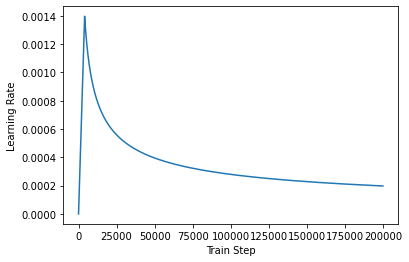

In [206]:
# 커스텀 학습률 스케줄링 시각화

sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

<br>

### 4. 모델 컴파일 <br><br>

손실 함수 (Loss function) 와 커스텀 된 학습률 (learning rate) 을 사용하여 모델을 컴파일

<br>

In [207]:
# 모델 컴파일
# 손실함수, 커스텀 학습률 사용

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

<br>

### 5. 모델 학습

20 EPOCHS 학습

<br>

In [208]:
# 모델 학습

EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 14s 74ms/step - loss: 1.4555 - accuracy: 0.0241
Epoch 2/20
185/185 [==============================] - 14s 74ms/step - loss: 1.1776 - accuracy: 0.0494
Epoch 3/20
185/185 [==============================] - 13s 72ms/step - loss: 1.0026 - accuracy: 0.0508
Epoch 4/20
185/185 [==============================] - 13s 72ms/step - loss: 0.9281 - accuracy: 0.0543
Epoch 5/20
185/185 [==============================] - 14s 74ms/step - loss: 0.8694 - accuracy: 0.0576
Epoch 6/20
185/185 [==============================] - 14s 75ms/step - loss: 0.8094 - accuracy: 0.0618
Epoch 7/20
185/185 [==============================] - 14s 76ms/step - loss: 0.7434 - accuracy: 0.0677
Epoch 8/20
185/185 [==============================] - 14s 74ms/step - loss: 0.6705 - accuracy: 0.0754
Epoch 9/20
185/185 [==============================] - 14s 73ms/step - loss: 0.5915 - accuracy: 0.0840
Epoch 10/20
185/185 [==============================] - 13s 71ms/step - loss: 0.509

<br>

## 챗봇 테스트 <br><br>

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다. <br><br>

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다. <br>
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다. <br>
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다. <br>
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다. <br>
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다. <br>
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다. <br> <br>

위의 과정을 모두 담은 decoder_inference() 함수를 작성

<br>

In [209]:
# 예측을 위한 decoder_inference() 함수를 작성

def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

<br>

임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 <br>
sentence_generation() 함수 작성

<br>

In [210]:
# decoder_inference() 함수를 호출하여 문장 생성하는 함수 작성

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

<br>

### 챗봇으로 문장 생성 테스트

<br>

In [211]:
# 테스트1. 질문

sentence_generation('요즘 어떻게 지내?')

입력 : 요즘 어떻게 지내?
출력 : 잘 지내고 있어요.


'잘 지내고 있어요.'

In [212]:
# 테스트2. 문장

sentence_generation('기분이 안 좋아 보여.')

입력 : 기분이 안 좋아 보여.
출력 : 먼저 다가가 보세요.


'먼저 다가가 보세요.'

<br>

## 총평 <br><br>

### 정규표현식 수정 <br><br>

- 한글 데이터를 학습하기 때문에 전처리를 위한 정규표현식에 알파벳에 추가로 한글 ```ㄱ-ㅎ가-힣``` <br><br>

- 트랜스포머 자연어 처리 모델은 문장 내 단어의 위치에 대한 정보도 학습하기 때문에, <br>
문장의 위치와 단어에 따라 구두점의 유의할 것으로 판단하여 구두점 제거 처리를 하지 않고 학습 <br><br>

정규표현식을 수정 후 학습한 결과, <br>
구두점이 띄어져 출력되는 부분을 수정할 수 있었고, <br>
동시에 결과도 맥락상 더 자연스러움을 확인 할 수 있었습니다.

<br>